In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import yfinance as yf
import tensorflow as tf
from pandas_datareader.yahoo.daily import YahooDailyReader
from stockstats import StockDataFrame
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Define the list of stock tickers and the date range
stock_tickers = ['OXY']#, 'GOOGL', 'MSFT']  # Replace with your list of stock tickers
start_date = '1994-01-01'  # Replace with your desired start date
end_date = '2023-09-10'  # Replace with your desired end date
# end_date = datetime.today()

# Function to preprocess the data for LSTM model
def preprocess_data(stock_data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data['scaled_close'] = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))
    return stock_data


def preprocess_y(y):
    scaler = MinMaxScaler()
    reshaped_y = y.reshape(-1, 1)
    scaled_y = scaler.fit_transform(reshaped_y)
    # scaled_y = scaled.reshape(1, -1)
    print(scaled_y)
    return scaled_y

# Function to create sequences for training
def create_sequences(data, sequence_length, prediction_window):
    X = []
    y = []
    for i in range(len(data) - sequence_length - prediction_window + 1):
        X.append(data[i:i+sequence_length])
        future_price = data[i+sequence_length:i+sequence_length+prediction_window]
        current_price = data[i+sequence_length-1]
        price_change = future_price - current_price
        y.append(1 if np.any(price_change > 0) else 0)
    return np.array(X), np.array(y)

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    # if true_future.any():
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
        label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

# def multivariate_data(dataset, target, start_index, end_index, history_size,
#                       target_size, step, single_step=False):
#     data = []
#     labels = []

#     start_index = start_index + history_size
#     if end_index is None:
#         end_index = len(dataset) - target_size

#     for i in range(start_index, end_index):
#         indices = range(i-history_size, i, step)
        
#         data.append(dataset[indices])

#         if single_step:
#             labels.append(target[i+target_size])
#         else:
#             labels.append(target[i:i+target_size])

#     return np.array(data), np.array(labels)

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        
        data.append(dataset[indices])
        if single_step:
            labels.append(target[i+target_size])
        else:
            future_price = target[i+target_size]
            current_price = target[i]
            price_change = future_price - current_price
            direction = 1 if price_change > 0 else 0  # or -1 if you prefer
            labels.append([direction])

    return np.array(data), np.array(labels)

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

def multinew_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []   

    # start_index = start_index + history_size
    start_index = -history_size
    if end_index is None:
        end_index = len(dataset) 

    for i in range(start_index, end_index-target_size):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

    return np.array(data)

def prediction_plot(history, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(prediction[0])

    plt.plot(num_in, np.array(history), label='History')
    if prediction.any():
        # print(np.shape(np.arange(num_out)/STEP))
        # print(np.array(prediction)[0])
        plt.plot(np.arange(num_out)/STEP, np.array(prediction)[0], 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [2]:
# # Loop over each stock ticker
# # for ticker in stock_tickers:
# # Download stock price data using yfinance

[*********************100%%**********************]  1 of 1 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

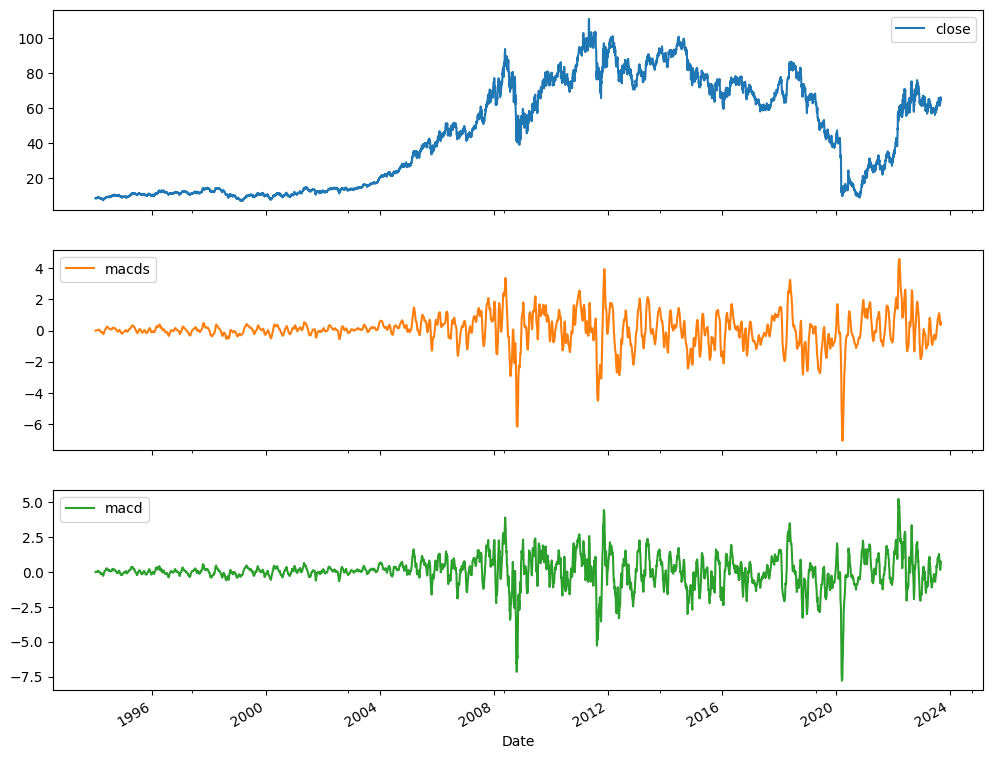

In [3]:
ticker = stock_tickers[0]

# df = YahooDailyReader(ticker, start='2018-01-01', end=datetime.now())
df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
df = StockDataFrame.retype(df)
df.head()

features_considered = ['close','macds','macd']
features = df[features_considered]
features.index = df.index
features.head()

features.plot(subplots=True,figsize=[12,10])

In [4]:
# Assuming your dataframe is called 'df' with columns 'column1', 'column2', 'column3'
columns_to_normalize = ['close', 'macds', 'macd']

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the selected columns
scaler.fit(features[columns_to_normalize])

# Transform the selected columns using the scaler
features[columns_to_normalize] = scaler.transform(features[columns_to_normalize])

dataset = features.values

dataset

array([[0.01268859, 0.60572289, 0.59795592],
       [0.01211185, 0.60565896, 0.59785295],
       [0.01384211, 0.60582061, 0.5982517 ],
       ...,
       [0.56351485, 0.64393162, 0.64871799],
       [0.55388282, 0.64788479, 0.6498393 ],
       [0.56072155, 0.65208173, 0.65446792]])

In [5]:
# Hyperparameters
BATCH_SIZE = 8
BUFFER_SIZE = 1000
TRAIN_SPLIT = int(df.shape[0] * 0.8)

In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        
        data.append(dataset[indices])
        if single_step:
            labels.append(target[i+target_size])
        else:
            future_price = target[i+target_size]
            current_price = target[i]
            price_change = future_price - current_price
            direction = 1 if price_change > 0 else 0  # or -1 if you prefer
            labels.append([direction])

    return np.array(data), np.array(labels)

past_history = 30
future_target = 5
STEP = 1


x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

# print(y_train_multi)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [7]:
# for x, y in val_data_multi.take(1):
#     multi_step_plot(x[0], y[0], np.array([0]))

In [8]:
# LSTM Parameters
EVALUATION_INTERVAL = 30#len(x_train_multi)//batch_size//2 #15
VALIDATION_INTERVAL = 30#len(x_val_multi)//batch_size//2
EPOCHS = 50
PATIENCE = 5

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)

In [9]:
# multi_step_model.build(x_train_multi.shape[-2:])
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add((tf.keras.layers.LSTM(32,
                                        #   return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:])))
multi_step_model.add(tf.keras.layers.Dropout(0.3))
multi_step_model.add(Dense(16))

# multi_step_model.add(tf.keras.layers.LSTM(16))
# multi_step_model.add(tf.keras.layers.Dropout(0.3))
# multi_step_model.add(Dense(8))

multi_step_model.add(Dense(1,activation='sigmoid'))



multi_step_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),loss='binary_crossentropy', metrics='binary_accuracy')
print(multi_step_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5153 (20.13 KB)
Trainable params: 5153 (20.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5,  min_delta=0.0005, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=VALIDATION_INTERVAL,
                                          callbacks=[early_stopping])

Epoch 1/50


2023-10-06 21:59:58.925498: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are 


30/30 [==============================] - ETA: 0s - loss: 0.6956 - binary_accuracy: 0.5083

2023-10-06 22:00:14.466867: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are 


30/30 [==============================] - 19s 204ms/step - loss: 0.6956 - binary_accuracy: 0.5083 - val_loss: 0.6903 - val_binary_accuracy: 0.5458
Epoch 2/50
30/30 [==============================] - 3s 92ms/step - loss: 0.6966 - binary_accuracy: 0.4917 - val_loss: 0.6963 - val_binary_accuracy: 0.4542
Epoch 3/50
30/30 [==============================] - 2s 68ms/step - loss: 0.6950 - binary_accuracy: 0.5000 - val_loss: 0.6955 - val_binary_accuracy: 0.4542
Epoch 4/50
30/30 [==============================] - 4s 144ms/step - loss: 0.6958 - binary_accuracy: 0.5000 - val_loss: 0.7054 - val_binary_accuracy: 0.4542
Epoch 5/50
30/30 [==============================] - 4s 136ms/step - loss: 0.6936 - binary_accuracy: 0.5375 - val_loss: 0.7064 - val_binary_accuracy: 0.4542
Epoch 6/50
30/30 [==============================] - 3s 86ms/step - loss: 0.6930 - binary_accuracy: 0.5167 - val_loss: 0.6991 - val_binary_accuracy: 0.4542


2023-10-06 22:00:33.713670: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [11]:
# plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

<Axes: title={'center': 'Accuracy'}>

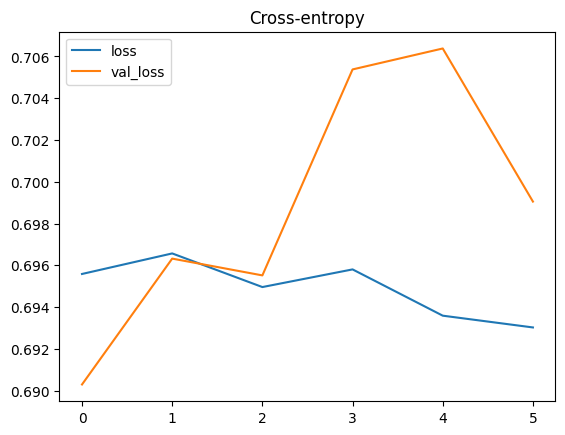

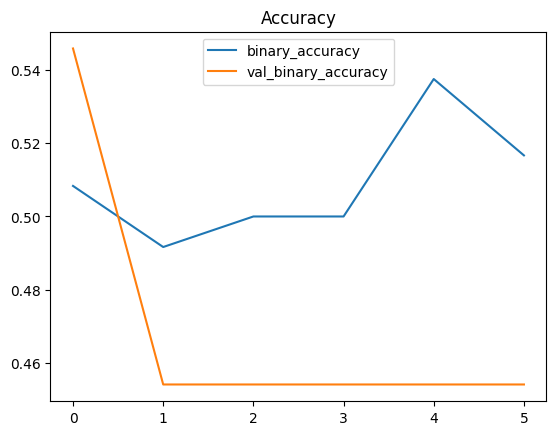

In [12]:
history_df = pd.DataFrame(multi_step_history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [13]:
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

x_val_multi = x_val_multi[-20:]
y_val_multi = y_val_multi[-20:]

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))

val_data_multi = val_data_multi.batch(BATCH_SIZE)#.repeat()

for x, y in val_data_multi.take(1):
    # multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
    print(multi_step_model.predict(x)[0])


# multi_step_model.predict(x)[0]

2023-10-06 22:00:35.836375: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are 
2023-10-06 22:00:36.074171: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1/1 [==============================] - 2s 2s/step
[0.51917076]


In [14]:
x_new_multi = multinew_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

x_new_multi = x_new_multi[-20:]



predictions = multi_step_model.predict(x_new_multi[-1:])#[0]
predictions = multi_step_model.predict(x_train_multi)

# predictions
# print(predictions)
for i in predictions:
    print(i)

2023-10-06 22:00:38.602962: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



  1/186 [..............................] - ETA: 33s

2023-10-06 22:00:41.919877: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



186/186 [==============================] - 3s 17ms/step
[0.5024604]
[0.5024643]
[0.5024623]
[0.50246245]
[0.5024569]
[0.5024406]
[0.50243646]
[0.502452]
[0.5024388]
[0.50241965]
[0.5024051]
[0.5023869]
[0.5023529]
[0.5023353]
[0.5023086]
[0.5022747]
[0.502243]
[0.5022189]
[0.5021984]
[0.50219846]
[0.5021653]
[0.5021505]
[0.50214964]
[0.50215054]
[0.50214684]
[0.5021359]
[0.50212955]
[0.50211537]
[0.5021169]
[0.50211614]
[0.5021197]
[0.5021196]
[0.5020716]
[0.5020466]
[0.50202376]
[0.5020174]
[0.5020116]
[0.50199634]
[0.5019679]
[0.5019633]
[0.50193495]
[0.5018911]
[0.50190467]
[0.50195354]
[0.5019822]
[0.50198704]
[0.50198984]
[0.5019776]
[0.5019987]
[0.5020361]
[0.50208867]
[0.5021373]
[0.5021772]
[0.50220007]
[0.50222695]
[0.50225675]
[0.50228685]
[0.5023153]
[0.5023407]
[0.5023558]
[0.50238234]
[0.5024141]
[0.5024401]
[0.50248706]
[0.5025467]
[0.5025741]
[0.5025833]
[0.5025993]
[0.5026024]
[0.5026176]
[0.502641]
[0.5026677]
[0.5026817]
[0.5027064]
[0.5027176]
[0.50273836]
[0.5027451

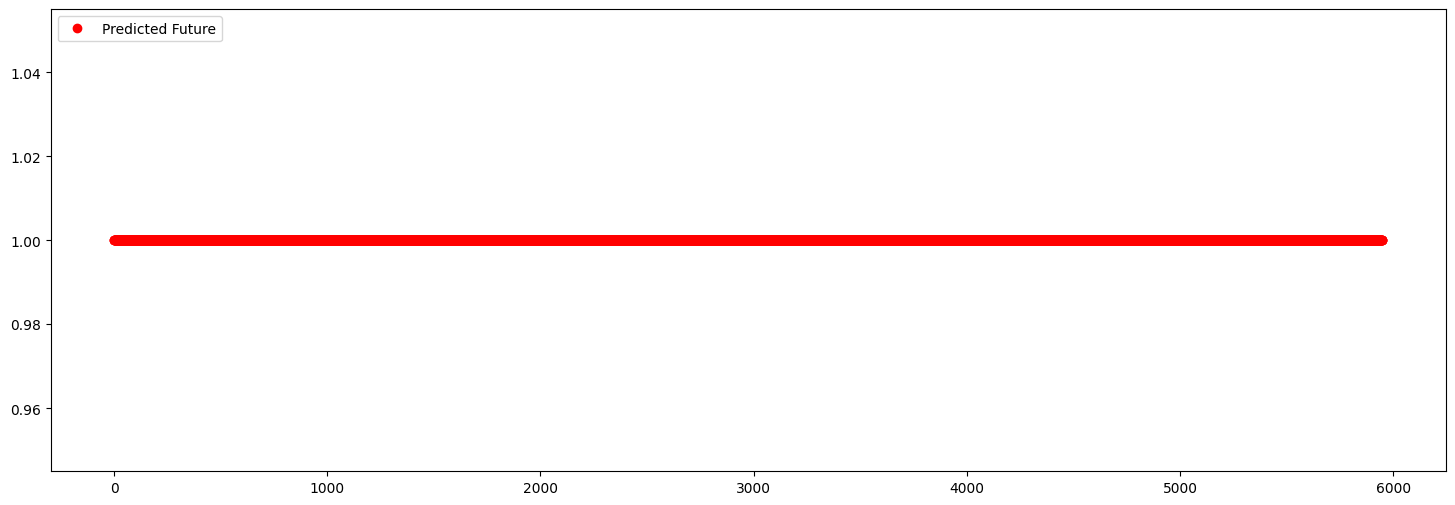

In [15]:
# New Predictions

def prediction_plot(prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(prediction))
    num_out = len(prediction)

    #if prediction.any():
        # print(np.shape(np.arange(num_out)/STEP))
        # print(np.array(prediction)[0])
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()


direction = [1 if i > 0.5 else 0 for i in predictions]

prediction_plot(direction)
# prediction_plot(x_new_multi[-1][:,0], predictions)


In [16]:
multi_step_model.save(f"model/model_bi_{ticker}.h5")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
